# loons - All products
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 20 # loons
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(8121, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            8121 non-null   int64  
 1   dimCustomerMasterId     8121 non-null   int64  
 2   customerNumber          8121 non-null   object 
 3   year                    8121 non-null   int64  
 4   productGrouping         8121 non-null   object 
 5   totalSpent              8121 non-null   float64
 6   recentDate              8121 non-null   object 
 7   attendancePercent       8121 non-null   float64
 8   renewedBeforeDays       8121 non-null   int64  
 9   isBuyer                 8121 non-null   object 
 10  source_tenure           8121 non-null   int64  
 11  tenure                  8121 non-null   int64  
 12  distToVenue             8121 non-null   float64
 13  totalGames              8121 non-null   int64  
 14  recency                 8121 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
         "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (6390, 14)
Unseen Data For Predictions: (1128, 14)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
     "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8334,0.8459,0.9399,0.8290,0.8809,0.6072,0.6211,0.3990
lr,Logistic Regression,0.8326,0.8268,0.9846,0.8042,0.8852,0.5875,0.6307,0.3950


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8438,0.8568,0.9326,0.8448,0.8865,0.6377,0.6458
1,0.8416,0.8577,0.9522,0.8309,0.8874,0.6245,0.6412
2,0.8269,0.8284,0.9551,0.8134,0.8786,0.5839,0.6072
3,0.8214,0.8380,0.9298,0.8213,0.8722,0.5793,0.5917
4,0.8324,0.8515,0.9185,0.8406,0.8779,0.6127,0.6188
5,0.8398,0.8560,0.9466,0.8321,0.8857,0.6217,0.6363
6,0.8416,0.8411,0.9522,0.8309,0.8874,0.6245,0.6412
7,0.8564,0.8592,0.9579,0.8441,0.8974,0.6613,0.6761
8,0.8232,0.8525,0.9298,0.8234,0.8734,0.5842,0.5962
9,0.8066,0.8176,0.9242,0.8084,0.8624,0.5421,0.5561


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(603, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
7518,20,351884179,1138427,2021,Mini Plan,1150.0,2021-09-05,0.543478,-25,TRUE,...,0,0,0.0,1,132,0,0,1,0.2372,0.7628
7519,20,351923520,919116,2021,Mini Plan,200.0,1970-01-01,0.000000,22,TRUE,...,0,0,0.0,1,132,0,0,1,0.3170,0.6830
7520,20,351996313,1164318,2021,Mini Plan,2659.2,2021-09-19,0.094828,25,TRUE,...,0,0,0.0,1,132,0,1,1,0.1893,0.8107
7521,20,351996319,1156819,2021,Mini Plan,350.0,2021-09-19,1.166667,24,TRUE,...,0,0,0.0,1,132,0,0,1,0.0756,0.9244
7522,20,351996333,1153714,2021,Full Season,5040.0,2021-09-19,0.394737,-21,TRUE,...,0,0,0.0,1,132,0,1,1,0.0526,0.9474


In [11]:
new_predictions["Label"].value_counts()

1    490
0    113
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.8, 1.0]       320
(0.6, 0.8]       123
(0.4, 0.6]        79
(0.2, 0.4]        52
(-0.001, 0.2]     29
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

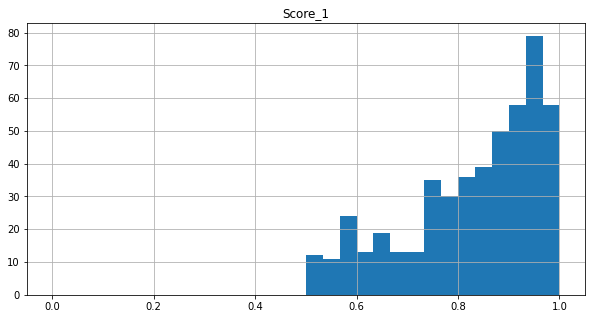

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

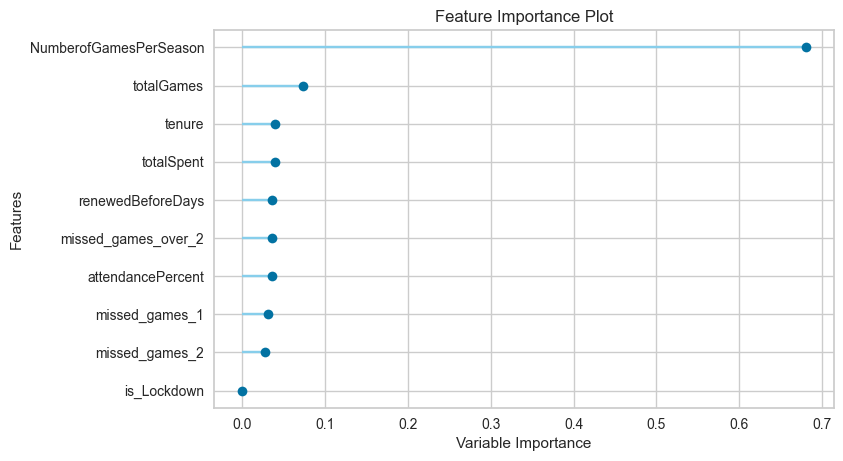

In [14]:
plot_model(best_model, plot='feature')

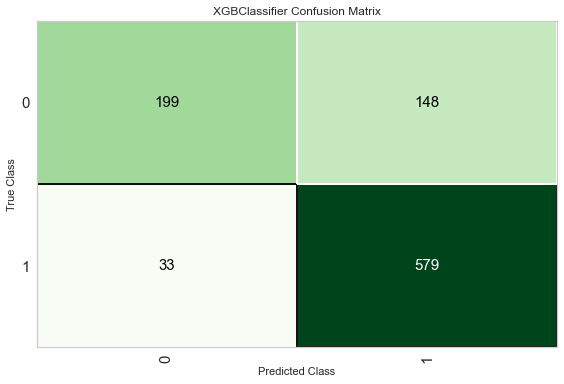

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

* the distribution doesn't look normal
* The ticketing data are in the top 3 feature importance
* The model makes more predictions of customers who won't buy
* The accuracy and the AUC decreased compared to using Full Season product

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?